## To what extent does exactly minimizing risk correspond to accurate support recovery? Does the extent of this correspondence differ between evaluation on the train vs. test set?

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

sys.path.append('..')

from utils import gen_covariance, gen_beta2, gen_data, get_cov_list
from utils import selection_accuracy
from sklearn.linear_model import LassoLars, lasso_path

from pyuoi.linear_model import UoI_Lasso

#### First fit to a model without correlations

In [2]:
n_features = 100
n_samples = 300

sigma = gen_covariance(n_features, 0, n_features, 1, 0)
beta = gen_beta2(n_features, n_features, 0.1)
X, X_test, y, y_test, ss = gen_data(n_samples, n_features, covariance = sigma, beta = beta)

In [3]:
uoil = UoI_Lasso(estimation_score = 'AIC')
uoil.fit(X, y)

UoI_Lasso(comm=None, copy_X=True, eps=0.001, estimation_frac=0.9,
     estimation_score='AIC', fit_intercept=True, max_iter=None,
     n_boots_est=48, n_boots_sel=48, n_lambdas=48, normalize=True,
     random_state=<module 'numpy.random' from 'C:\\Users\\akumar\\Anaconda3\\envs\\nse\\lib\\site-packages\\numpy\\random\\__init__.py'>,
     selection_frac=0.9, stability_selection=1.0, warm_start=None)

#### Calculate the exact risk of incurred by each estimate, as well as the corresponding selection accuracy

In [4]:
estimates = uoil.estimates_.reshape((-1, n_features))
selection_accuracies = selection_accuracy(beta.ravel(), estimates)

In [5]:
from risk import calc_KL_div, empirical_KL_estimate, MIC

In [8]:
KL_divs = np.zeros(selection_accuracies.size)
MC_KL_divs = np.zeros(selection_accuracies.size)
empirical_KL_divs = np.zeros(selection_accuracies.size)
AIC_train = np.zeros(selection_accuracies.size)
empirical_test = np.zeros(selection_accuracies.size)

naive_AIC = np.zeros(selection_accuracies.size)

for i in range(estimates.shape[0]):
    t0 = time.time()
    beta_hat = estimates[i, :]
    
    sigma_hat = np.mean((y.ravel() - X @ beta_hat.ravel())**2)
        
    KL_divs[i] = calc_KL_div(X @ beta_hat, np.sqrt(sigma_hat), np.sqrt(ss))
    empirical_KL_divs[i] = empirical_KL_estimate(y, X @ beta_hat, np.sqrt(sigma_hat))    
    AIC_train[i] = MIC(y, X @ beta_hat, np.sqrt(sigma_hat), np.count_nonzero(beta_hat), 2)
    
    sigma_hat = np.mean((y_test.ravel() - X_test @ beta_hat.ravel())**2)
    empirical_test[i] = empirical_KL_estimate(y_test, X_test @ beta_hat, 
                                              np.sqrt(sigma_hat))
    
    #print(time.time() - t0)

In [9]:
KL_divs

array([1261.98925004, 1974.24229032, 2078.29981418, ..., 2187.07869404,
       2186.99383605, 2186.96222351])

In [10]:
empirical_KL_divs

array([2222.49491448, 2830.62536671, 2933.661248  , ..., 3041.90548587,
       3041.82597974, 3041.79392531])

In [11]:
AIC_train

array([2222.49491448, 2832.62536671, 2939.661248  , ..., 3161.90548587,
       3165.82597974, 3169.79392531])

In [87]:
print(np.mean(MC_KL_divs - KL_divs))
print(np.mean(empirical_KL_divs - KL_divs))
print(np.mean(AIC_train - KL_divs))
print(np.mean(empirical_test - KL_divs))

0.014973708417536967
2.48783178715045
2.35834460766327
-9.328670362560166


In [ ]:
# AIC seems to slightly correct the bias, using test data results in a huge bias in the 
# other direction. What would have these different criteria selected?

In [114]:
model1 = estimates[np.argmin(KL_divs), :]
model2 = estimates[np.argmin(MC_KL_divs), :]
model3 = estimates[np.argmin(empirical_KL_divs), :]
model4 = estimates[np.argmin(AIC_train), :]
model5 = estimates[np.argmin(empirical_test), :]

In [115]:
KL_divs[142]

375.14739260576226

In [116]:
empirical_KL_divs[142]

375.64878710327235

In [101]:
empirical_test[142]

365.94140152105984

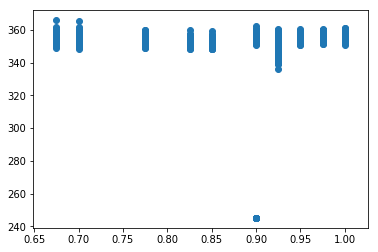

In [100]:
plt.scatter(selection_accuracies, empirical_test)

In [109]:
# What are the selection accuracies of the individual models prior to bagging selected by 
# UoI?

pre_bagging_selection_accuracies = selection_accuracy(beta.ravel(), uoil.best_estimates)

In [132]:
print(selection_accuracy(beta.ravel(), uoil.coef_))

[0.925]


In [133]:
print(selection_accuracy(beta.ravel(), uoil.alt_coef_))

[0.99]


In [134]:
selection_accuracy(beta.ravel(), uoil.best_estimates)

array([0.92 , 0.92 , 0.93 , 0.935, 0.93 , 0.935, 0.935, 0.925, 0.92 ,
       0.87 , 0.93 , 0.89 , 0.87 , 0.935, 0.925, 0.935, 0.935, 0.935,
       0.93 , 0.89 , 0.935, 0.935, 0.87 , 0.925, 0.93 , 0.935, 0.915,
       0.925, 0.92 , 0.92 , 0.92 , 0.935, 0.92 , 0.935, 0.92 , 0.87 ,
       0.87 , 0.92 , 0.92 , 0.915, 0.935, 0.93 , 0.93 , 0.935, 0.92 ,
       0.935, 0.935, 0.92 ])

In [135]:
selection_accuracy(beta.ravel(), uoil.alt_estimates)

array([0.985, 0.99 , 0.99 , 0.99 , 0.99 , 0.99 , 0.99 , 0.985, 0.99 ,
       0.975, 0.99 , 0.99 , 0.975, 0.99 , 0.99 , 0.99 , 0.985, 0.99 ,
       0.99 , 0.99 , 0.99 , 0.99 , 0.99 , 0.99 , 0.99 , 0.985, 0.99 ,
       0.99 , 0.975, 0.99 , 0.99 , 0.99 , 0.975, 0.99 , 0.99 , 0.975,
       0.99 , 0.99 , 0.99 , 0.99 , 0.99 , 0.985, 0.99 , 0.99 , 0.985,
       0.99 , 0.985, 0.99 ])

In [117]:
# UoI selection accuracy
print(selection_accuracy(beta.ravel(), uoil.coef_))
print(selection_accuracy(beta.ravel(), uoil.alt_coef_))

# Selection accuracy of our individual models
print(selection_accuracy(beta.ravel(), model1))
print(selection_accuracy(beta.ravel(), model2))
print(selection_accuracy(beta.ravel(), model3))
print(selection_accuracy(beta.ravel(), model4))
print(selection_accuracy(beta.ravel(), model5))

[0.975]
[0.925]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]


In [9]:
from risk import AIC

In [10]:
np.logspace(2, 5, 10).astype(int)

array([   100,    215,    464,   1000,   2154,   4641,  10000,  21544,
        46415, 100000])

In [12]:
# Verify our calculation. Calculate the AIC and the true KL divergence as n -> infinity
n_samples = np.logspace(2, 4, 10).astype(int)

sigma = gen_covariance(100, 0, 100, 1, 0)
beta = gen_beta2(100, 100, 0.2)

uoil = UoI_Lasso(estimation_score = 'AIC')

AIC_scores = []
exact_risk = []

for i, n_samples_ in enumerate(n_samples):
    t0 = time.time()
    # Generate data
    X, X_test, y, y_test, ss = gen_data(n_samples_, 100, covariance = sigma, beta = beta)
    
    # Fit
    uoil.fit(X, y)
    
    # Calculate AIC
    estimates = uoil.estimates_.reshape((-1, 100))
    
    AIC_scores_ = np.zeros(estimates.shape[0])

    # True risk
    exact_risk_ = np.zeros(estimates.shape[0])
    
    for j in range(estimates.shape[0]):
        beta_hat = estimates[j, :]
        sigma_hat = np.mean((y.ravel() - X @ beta_hat.ravel())**2)

        AIC_scores_[j] = AIC(y, X @ beta_hat, 100)

        exact_risk_[j] = calc_KL_div(X @ beta_hat, np.sqrt(sigma_hat), np.sqrt(ss))

    AIC_scores.append(AIC_scores_)
    exact_risk.append(exact_risk_)
    print(time.time() - t0)

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

5.324917316436768
3.792511463165283
3.2490713596343994
3.7774295806884766
5.336975574493408
8.522321939468384
33.0973174571991
78.55883288383484
183.4587903022766
471.083575963974


In [ ]:
## Does the AIC asymptotically approximate the true error?
# How about a single leave k out estimate?

# How does this asymptotic behavior vary as a function of the sparsity of the underlying model?

In [20]:
# For each n, calculate the average error between the AIC and true risk

approx_error = np.zeros(len(n_samples))
approx_error_std = np.zeros(len(n_samples))

for i in range(len(n_samples)):
    
    approx_error[i] = np.mean(((AIC_scores[i] - exact_risk[i])**2))
    approx_error_std[i] = np.std(((AIC_scores[i] - exact_risk[i])**2))


<ErrorbarContainer object of 3 artists>

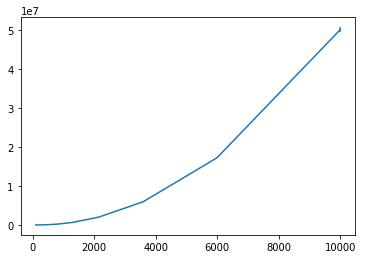

In [21]:
plt.errorbar(n_samples, approx_error, approx_error_std)

In [ ]:
# There is good evidence to suggest that the selection accuracy boost occurs at the level
# of individual model selection problems (and not the final bagging) - this still needs to 
# be systematically evaluated.

# Then, the question is, how does do the various risk estimators compare as we 
# vary the model sparsity and the number of samples. Need to prepare simulations 
# that get at this question

# Quickly, does cross-validation as opposed to a single out of sample estimate improve
# or remove the advantage we get?